In [ ]:
# Copyright 2019 NVIDIA Corporation. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

<img src="http://developer.download.nvidia.com/compute/machine-learning/frameworks/nvidia_logo.png" style="width: 90px; float: right;">

# Mask R-CNN Training and Inference Demo

## Overview

Mask R-CNN is a convolution-based neural network architecture for the task of object instance segmentation. The original paper describing the model can be found at [https://arxiv.org/abs/1703.06870](https://arxiv.org/abs/1703.06870). NVIDIA’s Mask R-CNN is an optimized version of [Facebook’s implementation](https://github.com/facebookresearch/maskrcnn-benchmark), leveraging mixed precision arithmetic and tensor cores for faster training while maintaining comparable accuracy with single precision (FP32) training.

The major differences between the official implementation of the paper and our version of Mask R-CNN are as follows:

- Mixed precision support with [PyTorch automatic mixed precision (AMP)](https://github.com/NVIDIA/apex).
- Gradient accumulation to simulate larger batches.
- Custom fused CUDA kernels for faster computations.


### Learning objectives

This notebook demonstrates the steps for training a Mask R-CNN model using 1 or multiple GPUs. We then employ the trained model to make inference on new images.

## Content
1. [Requirements](#1)
1. [Data download and preprocessing](#2)
1. [Training](#3)
1. [Testing trained model](#4)


<a id="1"></a>
## 1. Requirements


### 1.1 Docker container
The most convenient way to make use of the NVIDIA Mask R-CNN model is via a docker container, which provides a self-contained, isolated and re-producible environment for all experiments. Refer to the [Quick Start Guide section](https://github.com/NVIDIA/DeepLearningExamples/tree/master/PyTorch/Segmentation/MaskRCNN#requirements) of the Readme documentation for a comprehensive guide. We briefly summarize the steps here.

First, clone the repository:

```
git clone https://github.com/NVIDIA/DeepLearningExamples.git
cd DeepLearningExamples/PyTorch/Segmentation/MaskRCNN
```

Next, build the NVIDIA Mask R-CNN container:

```
cd pytorch
docker build --rm -t nvidia_joc_maskrcnn_pt .
```

Then launch the container with:

```
PATH_TO_COCO='/path/to/coco-2014'
MOUNT_LOCATION='/datasets/data'
NAME='nvidia_maskrcnn'

docker run --it --runtime=nvidia -p 8888:8888 -v $PATH_TO_COCO:/$MOUNT_LOCATION --rm --name=$NAME --shm-size=1g --ulimit memlock=-1 --ulimit stack=67108864 --ipc=host nvidia_joc_maskrcnn_pt
```
where `/path/to/coco-2014` is the path on the host machine where the data was/is to be downloaded. More on data set preparation in the next section.

Within the docker interactive bash session, start Jupyter with

```
jupyter notebook --ip 0.0.0.0 --port 8888
```

Then open the Jupyter GUI interface on your host machine at http://localhost:8888. Within the container, this notebook itself is located at `/workspace/object_detection/demo`.

### 1.2 Hardware
This notebook can be executed on any CUDA-enabled NVIDIA GPU, although for efficient mixed precision training, a [Tensor Core NVIDIA GPU](https://www.nvidia.com/en-us/data-center/tensorcore/) is desired (Volta, Turing or newer architectures). 

In [ ]:
!nvidia-smi

<a id="2"></a>
## 2. Data download and preprocessing

This notebook demonstrates training and validation of the Mask R-CNN model on the [COCO 2014 dataset](http://cocodataset.org/#download). If not already available locally, the following [script](https://github.com/NVIDIA/DeepLearningExamples/blob/master/PyTorch/Segmentation/MaskRCNN/download_dataset.sh) in the repository provides a convenient way to download and extract all the necessary data in one go. Be mindful of the size of the raw data (~20GB). The script makes use of `wget` and will automatically resume if disrupted. Once downloaded, the script invokes `dtrx` to extract the data.

In [ ]:
! wget https://raw.githubusercontent.com/NVIDIA/DeepLearningExamples/master/PyTorch/Segmentation/MaskRCNN/download_dataset.sh -P /workspace/object_detection/
! bash /workspace/object_detection/download_dataset.sh /datasets/data

Within the docker container, the final data directory should look like:

```
/datasets/data
  annotations/
    instances_train2014.json
    instances_val2014.json
  train2014/
    COCO_train2014_*.jpg
  val2014/
    COCO_val2014_*.jpg
```

<a id="3"></a>
## 3. Training

The shell script [train.sh](https://github.com/NVIDIA/DeepLearningExamples/blob/master/PyTorch/Segmentation/MaskRCNN/pytorch/scripts/train.sh) provides a convenient interface to launch training tasks. 
By default, invoking [train.sh](https://github.com/NVIDIA/DeepLearningExamples/blob/master/PyTorch/Segmentation/MaskRCNN/pytorch/scripts/train.sh) will make use of 8 GPUs, saves checkpoints every 2500 iterations and uses mixed precision training.

```
cd /workspace/object_detection/
bash scripts/train.sh
```

Note that, within [train.sh](https://github.com/NVIDIA/DeepLearningExamples/blob/master/PyTorch/Segmentation/MaskRCNN/pytorch/scripts/train.sh), it invokes the following Python command:

```python -m torch.distributed.launch --nproc_per_node=8 tools/train_net.py --config-file "configs/e2e_mask_rcnn_R_50_FPN_1x.yaml" DTYPE "float16"```

which launches pytorch distributed training with 8 GPUs, using the train script in [tools/train_net.py](https://github.com/NVIDIA/DeepLearningExamples/blob/master/PyTorch/Segmentation/MaskRCNN/pytorch/tools/train_net.py). Various sample training configurations are available within the [configs](https://github.com/NVIDIA/DeepLearningExamples/tree/master/PyTorch/Segmentation/MaskRCNN/pytorch/configs) directory, for example, a [configuration file](https://github.com/NVIDIA/DeepLearningExamples/blob/master/PyTorch/Segmentation/MaskRCNN/pytorch/configs/e2e_mask_rcnn_R_50_FPN_1x_1GPU.yaml) for training using 1 GPU. 

### 3.1 Training with 1 GPU
We will now take a closer look at training a Mask-RCNN model using 1 GPU, using the below custom config script.

In [ ]:
%%bash
echo 'MODEL:
  META_ARCHITECTURE: "GeneralizedRCNN"
  WEIGHT: "catalog://ImageNetPretrained/MSRA/R-50"
  BACKBONE:
    CONV_BODY: "R-50-FPN"
    OUT_CHANNELS: 256
  RPN:
    USE_FPN: True
    ANCHOR_STRIDE: (4, 8, 16, 32, 64)
    PRE_NMS_TOP_N_TRAIN: 2000
    PRE_NMS_TOP_N_TEST: 1000
    POST_NMS_TOP_N_TEST: 1000
    FPN_POST_NMS_TOP_N_TEST: 1000
  ROI_HEADS:
    USE_FPN: True
  ROI_BOX_HEAD:
    POOLER_RESOLUTION: 7
    POOLER_SCALES: (0.25, 0.125, 0.0625, 0.03125)
    POOLER_SAMPLING_RATIO: 2
    FEATURE_EXTRACTOR: "FPN2MLPFeatureExtractor"
    PREDICTOR: "FPNPredictor"
  ROI_MASK_HEAD:
    POOLER_SCALES: (0.25, 0.125, 0.0625, 0.03125)
    FEATURE_EXTRACTOR: "MaskRCNNFPNFeatureExtractor"
    PREDICTOR: "MaskRCNNC4Predictor"
    POOLER_RESOLUTION: 14
    POOLER_SAMPLING_RATIO: 2
    RESOLUTION: 28
    SHARE_BOX_FEATURE_EXTRACTOR: False
  MASK_ON: True
DATASETS:
  TRAIN: ("coco_2014_train", "coco_2014_valminusminival")
  TEST: ("coco_2014_minival",)
DATALOADER:
  SIZE_DIVISIBILITY: 32
SOLVER:
  BASE_LR: 0.005
  WEIGHT_DECAY: 0.0001
  STEPS: (240000, 320000)
  MAX_ITER: 360000
  IMS_PER_BATCH: 4
TEST:
  IMS_PER_BATCH: 16
' > /workspace/object_detection/configs/custom_config.yml

Various configurable options within the above configuration file can be modified, for example, the learning rate `BASE_LR`, training batch size `IMS_PER_BATCH` or number of train iterations `MAX_ITER`. The training process will start from a pre-trained Resnet-50 backbone model downloaded from `https://dl.fbaipublicfiles.com/detectron/ImageNetPretrained/MSRA/R-50.pkl`.

#### Training with full precision (FP32)
Next, we launch the training script using the [custom configuration script](../configs/custom_config.yml) just created above. A full training cycle with 360000 iterations on the COCO-2014 data on a single GPU might take as much as 1.5 days on an NVIDIA V100 GPU. 

In [ ]:
%run ../tools/train_net.py --config-file "/workspace/object_detection/configs/custom_config.yml" DTYPE "float32" OUTPUT_DIR ./results/1GPU-FP32/ 

Upon completion, the final model is saved to `./results/1GPU-FP32/model_final.pth`.

#### Training with mixed-precision
Next, we launch the training script using the same [custom configuration script](../configs/custom_config.yml) created above.

In [ ]:
%run ../tools/train_net.py --config-file "/workspace/object_detection/configs/custom_config.yml" DTYPE "float16" OUTPUT_DIR ./results/1GPU-FP16/ 

On compatible NVIDIA GPUs, the training script makes use of the Tensor cores for higher FP16 arithmetic throughput. On a V100 GPU, this shortens the training time by about 30%.

### 3.2 Training with 8 GPUs
We will now configure a training script to train a Mask-RCNN model using 8 GPUs. Thanks to having 8 GPUs, we can reduce the number of training iterations by a factor of 8, while the learning rate is also increased by 8 times to account for the larger global batch size.

In [ ]:
%%bash
echo 'MODEL:
  META_ARCHITECTURE: "GeneralizedRCNN"
  WEIGHT: "catalog://ImageNetPretrained/MSRA/R-50"
  BACKBONE:
    CONV_BODY: "R-50-FPN"
    OUT_CHANNELS: 256
  RPN:
    USE_FPN: True
    ANCHOR_STRIDE: (4, 8, 16, 32, 64)
    PRE_NMS_TOP_N_TRAIN: 2000
    PRE_NMS_TOP_N_TEST: 1000
    POST_NMS_TOP_N_TEST: 1000
    FPN_POST_NMS_TOP_N_TEST: 1000
    FPN_POST_NMS_TOP_N_TRAIN: 4000
  ROI_HEADS:
    USE_FPN: True
  ROI_BOX_HEAD:
    POOLER_RESOLUTION: 7
    POOLER_SCALES: (0.25, 0.125, 0.0625, 0.03125)
    POOLER_SAMPLING_RATIO: 2
    FEATURE_EXTRACTOR: "FPN2MLPFeatureExtractor"
    PREDICTOR: "FPNPredictor"
  ROI_MASK_HEAD:
    POOLER_SCALES: (0.25, 0.125, 0.0625, 0.03125)
    FEATURE_EXTRACTOR: "MaskRCNNFPNFeatureExtractor"
    PREDICTOR: "MaskRCNNC4Predictor"
    POOLER_RESOLUTION: 14
    POOLER_SAMPLING_RATIO: 2
    RESOLUTION: 28
    SHARE_BOX_FEATURE_EXTRACTOR: False
  MASK_ON: True
DATASETS:
  TRAIN: ("coco_2014_train", "coco_2014_valminusminival")
  TEST: ("coco_2014_minival",)
DATALOADER:
  SIZE_DIVISIBILITY: 32
SOLVER:
  BASE_LR: 0.04
  WEIGHT_DECAY: 0.0001
  STEPS: (36000, 48000)
  MAX_ITER: 50000
  IMS_PER_BATCH: 32
TEST:
  IMS_PER_BATCH: 8
' > /workspace/object_detection/configs/custom_config_8_GPUs.yml

#### Training with full precision

In [ ]:
%run -m torch.distributed.launch -- --nproc_per_node=8 ../tools/train_net.py --config-file "/workspace/object_detection/configs/custom_config_8_GPUs.yml" DTYPE "float32" OUTPUT_DIR ./results/8GPU-FP32/

If the Jupyter graphical interface does not update the training progress on the fly, you can observe the information being printed in the shell window from where you launched Jupyter. 

#### Training with mixed-precision
We now launch the training process using mixed precision. Observe the information being printed in the shell window from where you launched Jupyter. 

In [ ]:
%run -m torch.distributed.launch -- --nproc_per_node=8 ../tools/train_net.py --config-file "/workspace/object_detection/configs/custom_config_8_GPUs.yml" DTYPE "float16" OUTPUT_DIR ./results/8GPU-FP16/

<a id="4"></a>
## 4. Testing trained model

After model training has completed, we can test the trained model against the COCO-2014 validation set. First, we create a new configuration file for the test. Note: you must point the model `WEIGHT` parameter to a final model checkpoint, e.g. `./results/8GPU-FP32/model_final.pth`.

In [ ]:
%%bash
echo 'MODEL:
  META_ARCHITECTURE: "GeneralizedRCNN"
  WEIGHT: "./results/8GPU-FP16/model_final.pth"
  BACKBONE:
    CONV_BODY: "R-50-FPN"
    OUT_CHANNELS: 256
  RPN:
    USE_FPN: True
    ANCHOR_STRIDE: (4, 8, 16, 32, 64)
    PRE_NMS_TOP_N_TRAIN: 2000
    PRE_NMS_TOP_N_TEST: 1000
    POST_NMS_TOP_N_TEST: 1000
    FPN_POST_NMS_TOP_N_TEST: 1000
  ROI_HEADS:
    USE_FPN: True
  ROI_BOX_HEAD:
    POOLER_RESOLUTION: 7
    POOLER_SCALES: (0.25, 0.125, 0.0625, 0.03125)
    POOLER_SAMPLING_RATIO: 2
    FEATURE_EXTRACTOR: "FPN2MLPFeatureExtractor"
    PREDICTOR: "FPNPredictor"
  ROI_MASK_HEAD:
    POOLER_SCALES: (0.25, 0.125, 0.0625, 0.03125)
    FEATURE_EXTRACTOR: "MaskRCNNFPNFeatureExtractor"
    PREDICTOR: "MaskRCNNC4Predictor"
    POOLER_RESOLUTION: 14
    POOLER_SAMPLING_RATIO: 2
    RESOLUTION: 28
    SHARE_BOX_FEATURE_EXTRACTOR: False
  MASK_ON: True
DATASETS:
  TRAIN: ("coco_2014_train", "coco_2014_valminusminival")
  TEST: ("coco_2014_minival",)
DATALOADER:
  SIZE_DIVISIBILITY: 32
SOLVER:
  BASE_LR: 0.005
  WEIGHT_DECAY: 0.0001
  STEPS: (240000, 360000)
  MAX_ITER: 360000
  IMS_PER_BATCH: 4
TEST:
  IMS_PER_BATCH: 16
' > /workspace/object_detection/configs/test_custom_config.yml

### Validating on the COCO-2014 mini evaluation data set
Next, we launch the evaluation script, which will read the COCO-2014 mini evaluation dataset of 5000 images and evaluate various quality metrics, such as recall, precision and IoU at various thresholds.

In [ ]:
%run ../tools/test_net.py \
    --config-file /workspace/object_detection/configs/test_custom_config.yml \
    DTYPE "float16" \
    DATASETS.TEST "(\"coco_2014_minival\",)" \
    OUTPUT_DIR ./results/8GPU-FP16/evaluation \
    TEST.IMS_PER_BATCH 1

### Testing on new images

We will now launch an interactive testing, where you can load new test images. First, we load some required libraries and define some helper functions to load images.

In [23]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

import requests
from io import BytesIO
from PIL import Image
import numpy as np

# this makes our figures bigger
pylab.rcParams['figure.figsize'] = 20, 20

from maskrcnn_benchmark.config import cfg
from ..demo.predictor import COCODemo

def load(url):
    """
    Given an url of an image, downloads the image and
    returns a PIL image
    """
    response = requests.get(url)
    pil_image = Image.open(BytesIO(response.content)).convert("RGB")
    # convert to BGR format
    image = np.array(pil_image)[:, :, [2, 1, 0]]
    return image

def imshow(img):
    plt.imshow(img[:, :, [2, 1, 0]])
    plt.axis("off")

ValueError: attempted relative import beyond top-level package

Next, we load the trained model specified in the test configuration file, e.g. from `./results/8GPU-FP32/model_final.pth`.

In [ ]:
config_file = "/workspace/object_detection/configs/test_custom_config.yml"

# update the config options with the config file
cfg.merge_from_file(config_file)
# manual override some options
cfg.merge_from_list(["MODEL.DEVICE", "cuda"])

coco_demo = COCODemo(
    cfg,
    min_image_size=800,
    confidence_threshold=0.7,
)

User now can load a test image from any public URL.

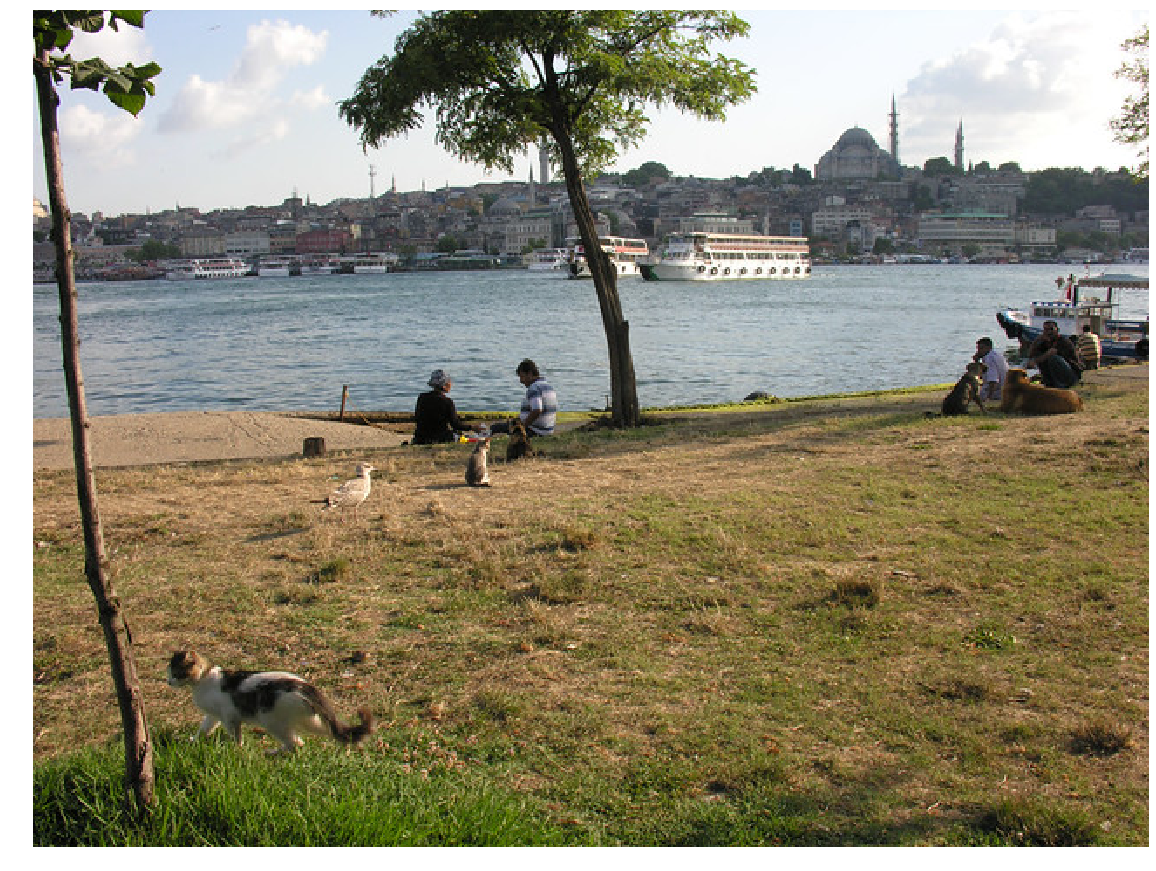

In [21]:
# from http://cocodataset.org/#explore?id=345434
image = load("http://farm3.staticflickr.com/2469/3915380994_2e611b1779_z.jpg")
imshow(image)


The prediction result is then displayed.

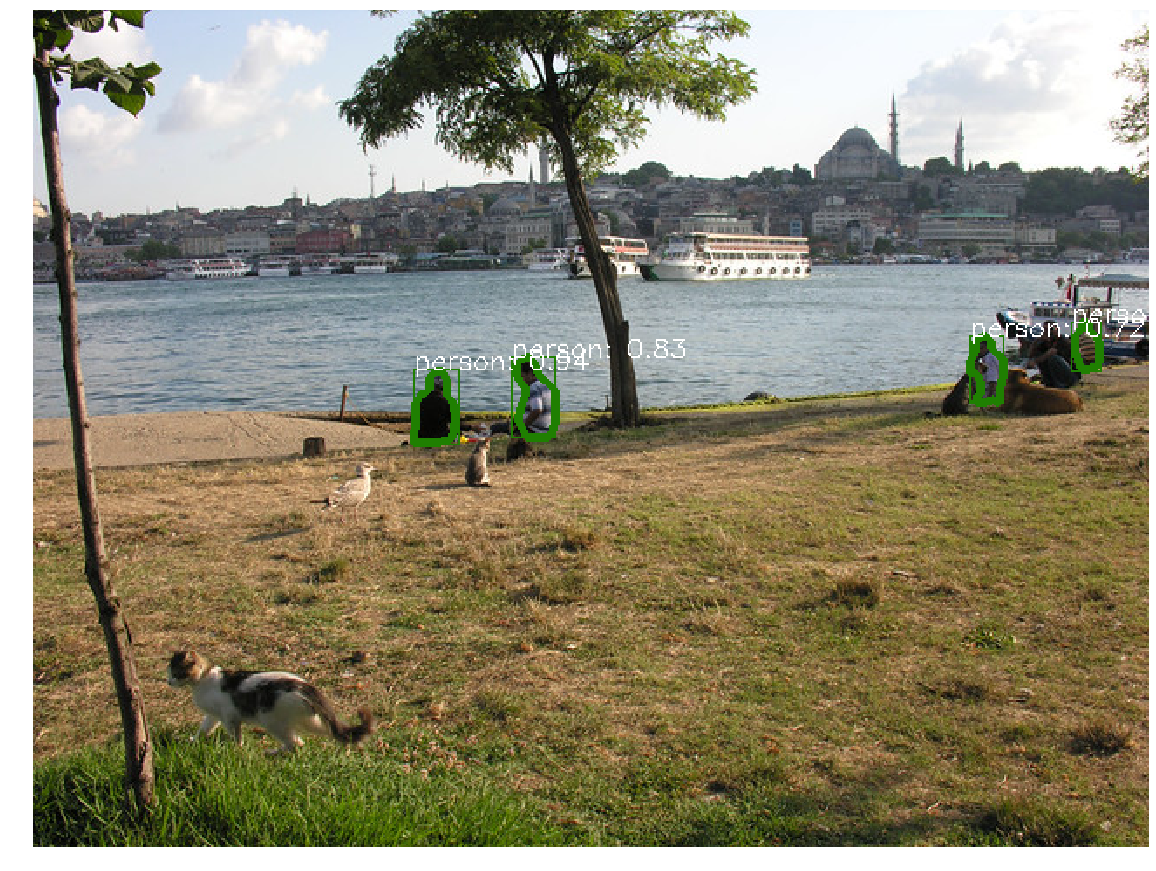

In [22]:
# compute predictions
predictions = coco_demo.run_on_opencv_image(image)
imshow(predictions)

# Conclusion

In this notebook, we have walked through the complete process of preparing the container and data required for training Mask-RCNN models. We have also investigated various training options, trained and tested Mask-RCNN models with various configurations.

## What's next
Now it's time to try the MaskR-CNN on your own data. Observe the performance impact of mixed precision training while comparing the final accuracy of the models trained with FP32 and mixed precision.
